In [126]:
import re
import os
import numpy as np
from proscript import *
import sentencepiece as spm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import ast
from collections import Counter
from dataclasses import dataclass
from random import shuffle
from shutil import copyfile
from hyphen import Hyphenator

h_es = Hyphenator('es_ES')
h_en = Hyphenator('en_US')

In [295]:
#LOAD HEROES CORPUS PATH DATA
proscript_data_file = "heroes_segment_paths_eval.txt"

In [285]:
#Auxiliary read-write functions

def puncEstimate(punc):
    if '.' in punc:
        return '.'
    elif ',' in punc:
        return ','
    elif '?' in punc:
        return '?'
    elif '!' in punc:
        return '.'
    elif ':' in punc:
        return '.'
    elif ';' in punc:
        return ','
    elif '-' in punc:
        return '.'
    else:
        return ''

def get_proscript_transcript(input_proscript, punctuation_as_token=False, reduce_punc=True):
    input_tokens = []

    for i, w in enumerate(input_proscript.word_list):
        if punctuation_as_token:
            if w.punctuation_before:
                if reduce_punc:
                    input_tokens.append(puncEstimate(w.punctuation_before))
                else:
                    input_tokens.append(w.punctuation_before)
            input_tokens.append(w.word)
            if w.punctuation_after:
                if reduce_punc:
                    input_tokens.append(puncEstimate(w.punctuation_after))
                else:
                    input_tokens.append(w.punctuation_after)
        else:
            input_tokens.append(w.punctuation_before + w.word + w.punctuation_after)
    return ' '.join(input_tokens)

#for reading old style (punctuation_before only)
def get_proscript_transcript_2(input_proscript):
    tokens = []
    for i, w in enumerate(input_proscript.word_list):
        if w.punctuation_before:
            tokens[-1] += w.punctuation_before
        tokens.append(w.word)
    del tokens[-1]
    return ' '.join(tokens)
    
    

def read_text_file(file):
	with open(file,'r') as f:
		return f.read()

In [296]:
#PARSE PROSCRIPT DATA FILE (File with paths to segment proscripts)
heroes_data_all = []
all_available_proscript_path = []  #input (EN) proscript paths
with open(proscript_data_file, 'r') as f:
    for l in f:
        es_txt_path, es_csv_path, en_txt_path, en_csv_path = l.split()
        all_available_proscript_path.append(en_csv_path)
        heroes_data_all.append((es_txt_path, es_csv_path, en_txt_path, en_csv_path))   

In [123]:
#SPLIT HEROES DATASET INTO DEVELOPMENT AND EVALUATION SETS
heroes_data_dev = []
heroes_data_dev_train = []
heroes_data_dev_val = []

heroes_data_eval = []

heroes_data_shuffled = heroes_data_all.copy()

shuffle(heroes_data_shuffled)

dev_ratio = 0.5
index = 0
while index < len(heroes_data_shuffled) * dev_ratio:
    heroes_data_dev.append(heroes_data_shuffled[index])
    index += 1
    
while index < len(heroes_data_shuffled):
    heroes_data_eval.append(heroes_data_shuffled[index])
    index += 1    
    
#Split Dev set to training and validation
validation_size = 200
index = 0
while index < validation_size:
    heroes_data_dev_val.append(heroes_data_dev[index])
    index += 1
    
while index < len(heroes_data_dev):
    heroes_data_dev_train.append(heroes_data_dev[index])
    index += 1  
    
print("Development: %i (train: %i, val: %i)"%(len(heroes_data_dev), len(heroes_data_dev_train), len(heroes_data_dev_val)))
print("Evaluation: %i "%(len(heroes_data_eval)))

Development: 3491 (train: 3291, val: 200)
Evaluation: 3490 


In [289]:
#PREPARE TEXT DATASET FROM HEROES SEGMENTS, PREPARE PATH FILES FOR SETS
heroes_txt_en_path = 'onmt-heroes/heroes.en.txt'
heroes_txt_es_path = 'onmt-heroes/heroes.es.txt'

def data2textfiles(dataset, en_txt_output, es_txt_output, get_en_transcript_from='txt', get_es_transcript_from='txt'):
    with open(en_txt_output, 'w') as f_en, open(es_txt_output, 'w') as f_es:
        for es_txt_path, es_csv_path, en_txt_path, en_csv_path in dataset:
            if get_en_transcript_from=='txt':
                en_transcript = read_text_file(en_txt_path).lower()
            elif get_en_transcript_from=='csv':
                p_en = Proscript()
                p_en.from_file(en_csv_path)
                en_transcript = get_proscript_transcript_2(p_en)
                
                
            if get_es_transcript_from=='txt':
                es_transcript = read_text_file(es_txt_path).lower()
            elif get_es_transcript_from=='csv':
                p_es = Proscript()
                p_es.from_file(es_csv_path)
                es_transcript = get_proscript_transcript_2(p_es)
                

            f_es.write(es_transcript + '\n')
            f_en.write(en_transcript + '\n')
            
def data2datafile(dataset, datafile_output):
    with open(datafile_output, 'w') as f:
        for es_txt_path, es_csv_path, en_txt_path, en_csv_path in dataset:
            f.write("%s\t%s\t%s\t%s\n"%(es_txt_path, es_csv_path, en_txt_path, en_csv_path))
                
# data2textfiles(heroes_data_all, 'onmt-heroes/heroes_all.en.txt', 'onmt-heroes/heroes_all.es.txt')
# data2textfiles(heroes_data_eval, 'onmt-heroes/heroes_eval.en.txt', 'onmt-heroes/heroes_eval.es.txt')
# data2textfiles(heroes_data_dev, 'onmt-heroes/heroes_dev.en.txt', 'onmt-heroes/heroes_dev.es.txt')
# data2textfiles(heroes_data_dev_train, 'onmt-heroes/heroes_dev_train.en.txt', 'onmt-heroes/heroes_dev_train.es.txt')
# data2textfiles(heroes_data_dev_val, 'onmt-heroes/heroes_dev_val.en.txt', 'onmt-heroes/heroes_dev_val.es.txt')

# data2datafile(heroes_data_eval, 'heroes_segment_paths_eval.txt')
# data2datafile(heroes_data_dev_train, 'heroes_segment_paths_dev_train.txt')
# data2datafile(heroes_data_dev_val, 'heroes_segment_paths_dev_val.txt')


In [ ]:
#PREPARE PunkProse DATASET FOR PROSODIC PUNCTUATION MODEL ADAPTATION FOR ENGLISH
#dev_train to train_samples
punkProse_train_samples_dir = '/Users/alp/Documents/Corpora/punk_data/heroes_corpus_Vsugardub/train_samples'
for _, _, _, en_csv_path in heroes_data_dev_train:
    dst_file = os.path.join(punkProse_train_samples_dir, os.path.basename(en_csv_path))
    copyfile(en_csv_path, dst_file)
    
#dev_val to dev_samples
punkProse_dev_samples_dir = '/Users/alp/Documents/Corpora/punk_data/heroes_corpus_Vsugardub/dev_samples'
for _, _, _, en_csv_path in heroes_data_dev_val:
    dst_file = os.path.join(punkProse_dev_samples_dir, os.path.basename(en_csv_path))
    copyfile(en_csv_path, dst_file)
    
#eval to test_samples
punkProse_test_samples_dir = '/Users/alp/Documents/Corpora/punk_data/heroes_corpus_Vsugardub/test_samples'
for _, _, _, en_csv_path in heroes_data_eval:
    dst_file = os.path.join(punkProse_test_samples_dir, os.path.basename(en_csv_path))
    copyfile(en_csv_path, dst_file)

punkProse_groundtruth_samples_dir = '/Users/alp/Documents/Corpora/punk_data/heroes_corpus_Vsugardub/test_groundtruth'
for _, _, _, en_csv_path in heroes_data_eval:
    
    dst_file = os.path.join(punkProse_groundtruth_samples_dir, os.path.splitext(os.path.basename(en_csv_path))[0] + '.txt')
    input_proscript = Proscript()
    input_proscript.from_file(en_csv_path)
    
    with open(dst_file, 'w') as f:
        f.write(get_proscript_transcript(input_proscript, punctuation_as_token=True, reduce_punc=True))

In [277]:
#PREPARE TEXT DATASET FROM punctuation recovered HEROES SEGMENTS, PREPARE PATH FILES FOR SETS

def to_punkprosed(path):
    return '/Users/alp/phdCloud/playground/punkHeroes/out_heroes_sugardub/csv/' + os.path.splitext(os.path.basename(path))[0] + '_punkProsed.csv'

heroes_data_eval_punkProsed = [(a,b,c,to_punkprosed(d)) for a,b,c,d in heroes_data_eval]  
data2textfiles(heroes_data_eval_punkProsed, 'onmt-heroes/heroes_eval_punkProsed.en.txt', 
               'onmt-heroes/heroes_eval_punkProsed.es.txt', 
               get_en_transcript_from='csv', 
              get_es_transcript_from='txt')



In [260]:
#Functions for unit counting
#Syllable counter. (Not very accurate for Spanish)
def no_syl_en(word):
    count = 0
    vowels = 'aeiouyáóúíéüö'
    word = word.lower().strip(".:;?!")
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count+=1
    if count == 0:
        count +=1
    return count

def no_syl_es(word):
    count = 0
    vowels = 'aeiouüö'
    vowels_acento = 'áóúíé'
    dipthongs = ['ai', 'au', 'eu', 'ei', 'oi', 'ou', 'ia', 'ie', 'io', 'iu', 'ua', 'ue', 'ui', 'uo', 'ió', 'ié']
    word = word.lower().strip(".:;?!")
    if word[0] in vowels + vowels_acento :
        count +=1
    for index in range(1,len(word)):
        #print(word[index-1:index+1])
        if word[index] in vowels + vowels_acento and word[index-1:index+1] not in dipthongs:
            #print(word[index])
            count +=1
#     if 'oos' in word:
#         count+=1
    if count == 0:
        count +=1
    return count

#Count number of words, syllables and characters in each sample
def get_unit_counts(dataset):
    heroes_unit_counts_en = []  # (Word, syllables, character)
    heroes_unit_counts_es = []  # (Word, syllables, character)

    for es_txt_path, es_csv_path, en_txt_path, en_csv_path in dataset:
        #read corresponding proscripts
        en_proscript = Proscript()
        en_proscript.from_file(en_csv_path)

        es_proscript = Proscript()
        es_proscript.from_file(es_csv_path)

        words_en = [w.word for w in en_proscript.word_list]
        words_es = [w.word for w in es_proscript.word_list]

        syl_en = [no_syl_en(w) for w in words_en]
        syl_es = [no_syl_es(w) for w in words_es]

        ch_en = []
        for w in words_en:
            ch_en += w

        ch_es = []
        for w in words_es:
            ch_es += w

        heroes_unit_counts_en.append((len(words_en), sum(syl_en), len(ch_en)))
        heroes_unit_counts_es.append((len(words_es), sum(syl_es), len(ch_es))) 

    return heroes_unit_counts_en, heroes_unit_counts_es

In [263]:
#Get unit count averages through samples
print("Word")
print(np.mean([c[0] for c in counts_heroes_data_all_en]))
print(np.mean([c[0] for c in counts_heroes_data_all_es]))
print("\nSyllable")
print(np.mean([c[1] for c in counts_heroes_data_all_en]))
print(np.mean([c[1] for c in counts_heroes_data_all_es]))
print("\nChar")
print(np.mean([c[2] for c in counts_heroes_data_all_en]))
print(np.mean([c[2] for c in counts_heroes_data_all_es]))

Word
8.032946569259419
6.931098696461825

Syllable
10.361982523993698
12.836699613235925

Char
32.05901733276035
29.486892995272882


8.032946569259419
7.9071633237822345
8.158693784016041
8.138863567304771
8.485
10.361982523993698
10.249856733524355
10.474076195932398
10.454876937101185
10.79


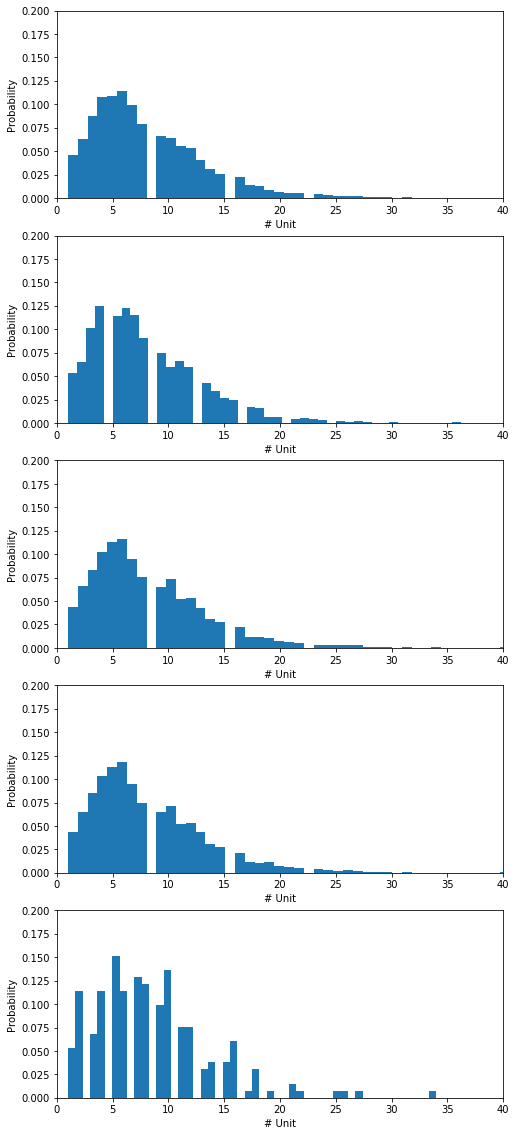

In [261]:
#ANALYZE UNIT COUNTS IN SETS
# #Get counts for all sets (takes long)
counts_heroes_data_all_en, counts_heroes_data_all_es = get_unit_counts(heroes_data_all)
counts_heroes_data_eval_en, counts_heroes_data_eval_es = get_unit_counts(heroes_data_eval)
counts_heroes_data_dev_en, counts_heroes_data_dev_es = get_unit_counts(heroes_data_dev)
counts_heroes_data_dev_train_en, counts_heroes_data_dev_train_es = get_unit_counts(heroes_data_dev_train)
counts_heroes_data_dev_val_en, counts_heroes_data_dev_val_es = get_unit_counts(heroes_data_dev_val)

#print average word counts
print(np.mean([c[0] for c in counts_heroes_data_all_en]))
print(np.mean([c[0] for c in counts_heroes_data_eval_en]))
print(np.mean([c[0] for c in counts_heroes_data_dev_en]))
print(np.mean([c[0] for c in counts_heroes_data_dev_train_en]))
print(np.mean([c[0] for c in counts_heroes_data_dev_val_en]))

#print average syllable counts
print(np.mean([c[1] for c in counts_heroes_data_all_en]))
print(np.mean([c[1] for c in counts_heroes_data_eval_en]))
print(np.mean([c[1] for c in counts_heroes_data_dev_en]))
print(np.mean([c[1] for c in counts_heroes_data_dev_train_en]))
print(np.mean([c[1] for c in counts_heroes_data_dev_val_en]))

#plot histogram of segment lengths w.r.t word count
to_plot = [counts_heroes_data_all_en, counts_heroes_data_eval_en, counts_heroes_data_dev_en, counts_heroes_data_dev_train_en, counts_heroes_data_dev_val_en]
plot_no = 1
unit_id = 0 #word
plt.figure(figsize=(8,20))
for counts in to_plot:
    plt.subplot(len(to_plot), 1, plot_no)
    x = [count[unit_id] for count in counts]
    # the histogram of the data
    plt.hist(x,density=1, bins=50) 
    plt.axis([0, 40, 0, 0.2]) 
    plt.xlabel('# Unit')
    plt.ylabel('Probability')
    plot_no += 1

In [291]:
#LOAD SENTENCE PIECING MODEL 
sp = spm.SentencePieceProcessor()
sp.Load("/Users/alp/Documents/Corpora/ted_en-es/sentencepieced_tedheroes/tedheroes.model")

#LOAD TRANSLATION OUTPUT
#translation_data_file = '/Users/alp/phdCloud/playground/dubbing-w-pause/onmt-heroes/test/ted-opt-heroes-noreset_step_74970.pt_heroes_eval_punkProsed.translation.out'
translation_data_file = '/Users/alp/phdCloud/playground/dubbing-w-pause/onmt-heroes/test/ted-opt-heroes-noreset_step_74970.pt_heroes.translation.out'

In [297]:
#PARSE TRANSLATION INFORMATION [of all sentences] WITH ATTENTION WEIGHTS
#Also does a proof check as some samples from the dataset have minor problems
all_input_pieces = []
all_pred_pieces = []
all_attention_weights = []
all_attention_binary = []
all_proscript = []
all_proscript_path = []

with open(translation_data_file, 'r') as f:
    sent_index = 0
    attention_first_line = True
    for l in f:
        if l.isspace():
            continue
        elif l.startswith(("GOLD", "PRED SCORE")):
            continue
        elif l.startswith("SENT"):
            input_pieces = ast.literal_eval(l[l.find(':') + 2:])
            continue
        elif l.startswith("PRED"):
            pred_pieces = l[l.find(':') + 2:].split()
            continue

        if attention_first_line:
            attention_first_line = False
            num_input_pieces = len(input_pieces)
            num_pred_pieces = len(pred_pieces)
            sent_attention_weights = np.empty([0, num_input_pieces])
            sent_attention_binary = np.empty([0, num_input_pieces])
            continue
            
        #take the rest to the attention matrices until EOS is seen
        try:
            weights = [float(w) if not w.startswith('*') else float(w[1:]) for w in l.split()[1:]]
            binary = [1 if w.startswith('*') else 0 for w in l.split()[1:]]
        except:
            print(l)
            break
        
        if not l.split()[0] == "</s>":
            sent_attention_weights = np.vstack([sent_attention_weights, weights])
            sent_attention_binary = np.vstack([sent_attention_binary, binary])
        else:
            #read corresponding proscript
            input_proscript = Proscript()
            input_proscript.from_file(all_available_proscript_path[sent_index])

            #make sure it matches with proscript info
            proscript_transcript = get_proscript_transcript(input_proscript)
            subtitle_transcript = sp.decode_pieces(input_pieces)
            
            if proscript_transcript == subtitle_transcript:
                #store information 
                all_proscript_path.append(all_available_proscript_path[sent_index])
                all_proscript.append(input_proscript)
                all_input_pieces.append(input_pieces)
                all_pred_pieces.append(pred_pieces)
                all_attention_weights.append(sent_attention_weights)
                all_attention_binary.append(sent_attention_binary)
            else:
                print("Problem at %s"%all_available_proscript_path[sent_index])
                print(subtitle_transcript)
                print(proscript_transcript)
                print("-----")
            attention_first_line = True
            sent_index += 1

In [305]:
inde = 29
print(all_input_pieces[inde])
subtitle_transcript = sp.decode_pieces(all_input_pieces[inde])
print('TRANSCRIPT:', sp.decode_pieces(all_input_pieces[inde]))

proscript_tokens, proscript_token_labels, input_phrase_structure = get_input_structure(all_proscript[inde])
#print(proscript_tokens)

proscript_transcript = ' '.join(proscript_tokens)
print('PROSCRIPT:', proscript_transcript)

pieces_from_tokens = []
for token in proscript_tokens:
    pieces_from_tokens.extend(sp.encode_as_pieces(token))
    
print(pieces_from_tokens)

if not subtitle_transcript == proscript_transcript:
    print("problem transcripts don't match")

if not len(subtitle_transcript.split()) == len(proscript_transcript.split()):
    print("problem transcript lengths don't match")

['▁this', '▁isn', "'", 't', '▁a', '▁really', '▁good', '▁time', '.', '▁is', '▁it', '▁important', '?']
TRANSCRIPT: this isn't a really good time. is it important?
PROSCRIPT: this isn't a really good time. is it important?
['▁this', '▁isn', "'", 't', '▁a', '▁really', '▁good', '▁time', '.', '▁is', '▁it', '▁important', '?']


In [308]:
input_tokens, input_token_labels, input_structure = get_input_structure(all_proscript[1])
for st in input_structure:
    print(st)
print(all_proscript_path[30])

Phrase(label=0, tokens=['do', 'you', 'have', 'any', 'idea', 'what', "you've", 'done', 'to', 'this', 'family'], transcript="do you have any idea what you've done to this family?", start_time=0.0, end_time=2.18, pause_after=1.38)
Phrase(label=1, tokens=['what', "you've", 'done', 'to', 'me'], transcript="what you've done to me?", start_time=3.56, end_time=4.48, pause_after=0.3)
/Users/alp/Movies/heroes/corpus_post/heroes_s3_8/spa-eng/segments_eng/heroes_s3_8_eng_aligned_eng0176.csv


In [ ]:
p1 = Phrase(tokens=['a', 'b'], transcript="a b", start_time=0.0)

In [299]:
#EXTRACT PHRASE STRUCTURE FROM INPUT SENT PROSCRIPT

@dataclass
#struct to store phrase information
class Phrase:
    label: int
    tokens: list
    transcript: str
    start_time: float
    end_time: float
    pause_after: float
        
def get_input_structure(input_proscript, min_segment_pause_interval=0.0):
    input_tokens = []
    input_token_labels = []
    curr_phrase_id = 0

    phrase_structure = []
    curr_phrase_tokens = []
    curr_phrase_transcript = ''
    get_start = True
    for i, w in enumerate(input_proscript.word_list):
        if get_start:
            #first token in phrase
            phrase_start_time = w.start_time
            get_start = False
            
        token = w.punctuation_before + w.word + w.punctuation_after #THIS IS NOT REALLY TOKEN BUT TEXT ENCLOSED IN WHITESPACE
        curr_phrase_transcript += token + ' '
        input_tokens.append(token)
        input_token_labels.append(curr_phrase_id)
        curr_phrase_tokens.append(w.word)
        
        
        #if there's a pause after the current word or if it is the last word, close the phrase
        if w.pause_after > min_segment_pause_interval or i == len(input_proscript.word_list) - 1:
            phrase = Phrase(label=curr_phrase_id,
                            tokens=curr_phrase_tokens, 
                            transcript=curr_phrase_transcript.strip(), 
                            start_time=phrase_start_time, 
                            end_time=w.end_time, 
                            pause_after=w.pause_after)
            
            phrase_structure.append(phrase)
            
            #close phrase
            curr_phrase_id += 1
            curr_phrase_tokens = []
            curr_phrase_transcript = ''
            get_start = True
    
    return input_tokens, input_token_labels, phrase_structure
    
#labels piece sequence with phrase labels w.r.t input token labels
#REFACTOR: this function can be merged to get_input_structure()
def token_to_piece_labels(input_pieces, input_tokens, input_token_labels):
    #label pieced tokens w.r.t proscript phrase labels
    input_piece_labels = []
    proscript_token_index = 0
    piece_index = 0
    curr_token_pieces = sp.EncodeAsPieces(input_tokens[proscript_token_index])
    while piece_index < len(input_pieces):
        try:
            token_piece = curr_token_pieces.pop(0)
        except:
            proscript_token_index += 1
            curr_token_pieces = sp.EncodeAsPieces(input_tokens[proscript_token_index])
            continue

        if input_pieces[piece_index] == token_piece:
            input_piece_labels.append(input_token_labels[proscript_token_index])
            piece_index += 1
        else:
            print("somethings not right in token alignment")

    return input_piece_labels

In [300]:
#MATCH INPUT PIECE LABELS TO OUTPUT PIECES USING BINARY ATTENTION MATRIX
#Naive (kopuk olabilir)
def map_piece_labels_naive(pred_pieces, sent_attention_binary):
    pred_piece_labels = []
    for piece_no, pred_piece in enumerate(pred_pieces):
        matching_input_piece_no = np.argmax(sent_attention_binary[piece_no])
        matching_input_piece = input_pieces[matching_input_piece_no]
        piece_label = input_piece_labels[matching_input_piece_no]
        pred_piece_labels.append(piece_label)
        #print(pred_piece + " - "  + matching_input_piece + " " + str(piece_label))
    
    return pred_piece_labels

In [301]:
#TRANSLATE PREDICTION PIECE LABELS TO PREDICTION TOKEN LABELS
def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get)

def piece_to_token(pred_pieces, pred_piece_labels):
    tokens = []
    token_labels = []
    token_label_votes = []
    for piece_index, piece in enumerate(pred_pieces):
        if piece.startswith('▁'):
            tokens.append(piece[1:])
            token_label_votes.append([pred_piece_labels[piece_index]])
        else:
            tokens[-1] += piece
            token_label_votes[-1].append(pred_piece_labels[piece_index])
    
    token_labels = [most_common(token_votes) for token_votes in token_label_votes]
    
    return tokens, token_labels

In [ ]:
print(pred_token_labels)
print(pred_tokens)
pred_phrase_structure = get_output_phrase_structure(pred_tokens, pred_token_labels, input_phrase_structure)
print(' '.join(pred_tokens))
for p in pred_phrase_structure:
    print(p)

In [ ]:
for pi in input_phrase_structure:
    print(pi)


In [302]:
#EXTRACT OUTPUT PHRASE STRUCTURE W.R.T INPUT PHRASE STRUCTURE
#requirements: 1. output_token_labels must be monotonously increasing
#2. there should be same number of labels in input and output

def get_output_phrase_structure(output_tokens, output_token_labels, input_structure):
    output_structure = []
    curr_phrase_id = 0
    curr_phrase_tokens = []
    
    for i, (tok, l) in enumerate(zip(output_tokens, output_token_labels)):
        t = strip_punctuation(tok) 
        if not l == curr_phrase_id:
            #close phrase
            phrase = Phrase(label=curr_phrase_id,
                            tokens=curr_phrase_tokens, 
                            transcript=' '.join(curr_phrase_tokens), 
                            start_time=input_structure[curr_phrase_id].start_time, 
                            end_time=input_structure[curr_phrase_id].end_time, 
                            pause_after=input_structure[curr_phrase_id].pause_after)
            
            output_structure.append(phrase)
            curr_phrase_id += 1
            curr_phrase_tokens = [t]
        else:
            curr_phrase_tokens.append(t)
    else:
        #get the final phrase
        phrase = Phrase(label=curr_phrase_id,
                            tokens=curr_phrase_tokens, 
                            transcript=' '.join(curr_phrase_tokens), 
                            start_time=input_structure[curr_phrase_id].start_time, 
                            end_time=input_structure[curr_phrase_id].end_time, 
                            pause_after=input_structure[curr_phrase_id].pause_after)
            
        output_structure.append(phrase)
            
    return output_structure

#strips punctuation from beginning and end of token
def strip_punctuation(token_string):
    word_being_processed = token_string
    punc_after = ""
    punc_before = ""
    
    if re.search(r"^\W", word_being_processed):
        punc = word_being_processed[:re.search(r"\w", word_being_processed).start()]
        punc_before += punc
        word_being_processed = word_being_processed[re.search(r"\w", word_being_processed).start():]

    #check end again (issue with quotations)
    word_reversed = word_being_processed[::-1]
    if re.search(r"^\W",word_reversed):
        punc = word_reversed[:re.search(r"\w", word_reversed).start()][::-1]
        punc_after = punc + punc_after
        word_being_processed = word_reversed[re.search(r"\w", word_reversed).start():][::-1]

    return word_being_processed

In [ ]:
word_being_processed = '......sdcs,,//'
punc_after = ""
punc_before = ""
        
if re.search(r"^\W", word_being_processed):
        punc = word_being_processed[:re.search(r"\w", word_being_processed).start()]
        punc_before += punc
        word_being_processed = word_being_processed[re.search(r"\w", word_being_processed).start():]

#check end again (issue with quotations)
word_reversed = word_being_processed[::-1]
if re.search(r"^\W",word_reversed):
    punc = word_reversed[:re.search(r"\w", word_reversed).start()][::-1]
    punc_after = punc + punc_after
    word_being_processed = word_reversed[re.search(r"\w", word_reversed).start():][::-1]
    
print(word_being_processed)

In [303]:
def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(12, 12))
    
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone_r')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90, fontsize=15)
    ax.set_yticklabels([''] + output_words, fontsize=15)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
show_attention(input_pieces, pred_pieces, sent_attention_weights)

In [304]:
def strictly_increasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

strictly_increasing([1,2,2,2,2,2,2,3,5,4])

False

In [ ]:
severe_problematic

In [ ]:
#BATCH PROCESS INPUT SEGMENTS->OUTPUT SEGMENTS
all_input_tokens = []
all_input_token_labels = []
all_input_piece_labels = []
all_pred_piece_labels = []
all_pred_tokens = []
all_pred_token_labels = []
all_input_phrase_structure = []
all_pred_phrase_structure = []

MIN_SEGMENT_PAUSE_INTERVAL = 0.5

severe_problematic= 0

for segment_no, (input_pieces, pred_pieces, input_proscript, sent_attention_binary, sent_attention_weights) in enumerate(zip(all_input_pieces, all_pred_pieces, all_proscript, all_attention_binary, all_attention_weights)):
    try:
        input_tokens, input_token_labels, input_phrase_structure = get_input_structure(input_proscript, MIN_SEGMENT_PAUSE_INTERVAL)
        input_piece_labels = token_to_piece_labels(input_pieces, input_tokens, input_token_labels)
        pred_piece_labels = map_piece_labels_naive(pred_pieces, sent_attention_binary)
        pred_tokens, pred_token_labels = piece_to_token(pred_pieces, pred_piece_labels)
        pred_phrase_structure = get_output_phrase_structure(pred_tokens, pred_token_labels, input_phrase_structure)
    except:
        input_tokens, input_token_labels, input_piece_labels, pred_piece_labels, pred_tokens, pred_token_labels = None, None, None, None, None, None
        print("Somethings wrong processing %i"%segment_no)
        severe_problematic += 1
        
    all_input_tokens.append(input_tokens)
    all_input_token_labels.append(input_token_labels)
    all_input_piece_labels.append(input_piece_labels)
    all_input_phrase_structure.append(input_phrase_structure)
    
    all_pred_piece_labels.append(pred_piece_labels)
    all_pred_tokens.append(pred_tokens)
    all_pred_token_labels.append(pred_token_labels)
    all_pred_phrase_structure.append(pred_phrase_structure)

In [309]:
#STUDY PARTICULAR DATA SAMPLE
WORKING_SENTENCE_NO = 11

input_pieces = all_input_pieces[WORKING_SENTENCE_NO]
pred_pieces = all_pred_pieces[WORKING_SENTENCE_NO]
input_proscript = all_proscript[WORKING_SENTENCE_NO]
sent_attention_binary = all_attention_binary[WORKING_SENTENCE_NO]
sent_attention_weights = all_attention_weights[WORKING_SENTENCE_NO]

# 1. read from processed batch
# input_tokens = all_input_tokens[WORKING_SENTENCE_NO]
# input_token_labels = all_input_token_labels[WORKING_SENTENCE_NO]
# input_piece_labels = all_input_piece_labels[WORKING_SENTENCE_NO]
# input_phrase_structure = all_input_phrase_structure[WORKING_SENTENCE_NO]

# pred_tokens = all_pred_tokens[WORKING_SENTENCE_NO]
# pred_piece_labels = all_pred_piece_labels[WORKING_SENTENCE_NO]
# pred_token_labels = all_pred_token_labels[WORKING_SENTENCE_NO]
# pred_phrase_structure = all_pred_phrase_structure[WORKING_SENTENCE_NO]

# 2. process your own
input_tokens, input_token_labels, input_phrase_structure = get_input_structure(input_proscript, min_segment_pause_interval=0.0)
input_piece_labels = token_to_piece_labels(input_pieces, input_tokens, input_token_labels)
pred_piece_labels = map_piece_labels_naive(pred_pieces, sent_attention_binary) 
pred_tokens, pred_token_labels = piece_to_token(pred_pieces, pred_piece_labels)
pred_phrase_structure = get_output_phrase_structure(pred_tokens, pred_token_labels, input_phrase_structure)

input_segments_from_tokens = [' '.join(p.tokens) for p in input_phrase_structure]

print("Input segments (from proscript tokens)")
print(input_segments_from_tokens)


pred_segment_pieces = [[] for i in range(max(pred_piece_labels) + 1)]
for t,i in zip(pred_pieces, pred_piece_labels):
    pred_segment_pieces[i].append(t)

pred_segments_from_pieces = [' '.join(segment_pieces) for segment_pieces in pred_segment_pieces]
    
print('\nSegmented output pieces')
print(pred_segments_from_pieces)


pred_segment_tokens = [[] for i in range(max(pred_token_labels) + 1)]
for t,i in zip(pred_tokens, pred_token_labels):
    pred_segment_tokens[i].append(t)

pred_segments_from_tokens = [' '.join(segment_tokens) for segment_tokens in pred_segment_tokens]
    
print("\nSegmented output tokens")
print(pred_segments_from_tokens)

#SHOW matched input and prediction segments
print("\nMatched input and pred segments")
full_input = ' '.join(input_segments_from_tokens)
full_translation = ' '.join(pred_segments_from_tokens)
print(full_input)
print(full_translation)
print()

for input_seg, pred_seg in zip(input_segments_from_tokens, pred_segments_from_tokens):
    print(">" + input_seg)
    print(">" + pred_seg)
    print()
    
#output files for synthesis
#1. plain translation string
file_prefix = "samples/s2_10_0223/translation"
with open (file_prefix + '.txt', 'w') as f_txt:
    f_txt.write(full_translation)
    
#2. phrase structure
phrase_output_file = "samples/s2_10_0223/output_phrase_structure.txt"
with open(phrase_output_file, 'w') as f:
    for st in pred_phrase_structure:
        f.write("%f\t%f\t%f\t%s\n"%(st.start_time, st.end_time, st.pause_after, st.tokens))

Input segments (from proscript tokens)
["you've done", 'so much for us', "we've done", 'so much for you', 'so much that', "we couldn't do for you any more if", 'you were to', 'leave']

Segmented output pieces
['▁has ▁hecho', '▁mucho ▁por ▁nosotros .', '▁hemos ▁hecho', '▁mucho ▁por ▁ti .', '▁tanto ▁que', '▁no ▁podíamos ▁hacer ▁para ▁ti , ▁si', '▁te ▁vas ▁a', '▁abandonar .']

Segmented output tokens
['has hecho', 'mucho por nosotros.', 'hemos hecho', 'mucho por ti.', 'tanto que', 'no podíamos hacer para ti, si', 'te vas a', 'abandonar.']

Matched input and pred segments
you've done so much for us we've done so much for you so much that we couldn't do for you any more if you were to leave
has hecho mucho por nosotros. hemos hecho mucho por ti. tanto que no podíamos hacer para ti, si te vas a abandonar.

>you've done
>has hecho

>so much for us
>mucho por nosotros.

>we've done
>hemos hecho

>so much for you
>mucho por ti.

>so much that
>tanto que

>we couldn't do for you any more if
>no 

In [ ]:
phrase_output_file = "samples/s2_10_0223/output_phrase_structure.txt"
with open(phrase_output_file, 'w') as f:
    for st in pred_phrase_structure:
        f.write("%f\t%f\t%f\t%s\n"%(st.start_time, st.end_time, st.pause_after, st.tokens))

In [ ]:
['i urge', 'each and every one of you...', 'to take up this cause,', 'spread the word...']


In [ ]:
#GO SAMPLE BY SAMPLE
start_from = 500
problem_count = 0
for sent_no in range(start_from, len(all_input_pieces)):
    input_pieces = all_input_pieces[sent_no]
    pred_pieces = all_pred_pieces[sent_no]
    input_proscript = all_proscript[sent_no]
    sent_attention_binary = all_attention_binary[sent_no]
    sent_attention_weights = all_attention_weights[sent_no]
    proscript_path = all_proscript_path[sent_no]

    # 1. read from processed batch
    input_tokens = all_input_tokens[sent_no]
    input_token_labels = all_input_token_labels[sent_no]
    input_piece_labels = all_input_piece_labels[sent_no]
    input_phrase_structure = all_input_phrase_structure[sent_no]
    pred_tokens = all_pred_tokens[sent_no]
    pred_piece_labels = all_pred_piece_labels[sent_no]
    pred_token_labels = all_pred_token_labels[sent_no]
    pred_phrase_structure = all_pred_phrase_structure[sent_no]
    
    if pred_token_labels == None:
        print("SAMPLE %i problematic"%sent_no)
        continue
    
    
#     input_segment_tokens = [[] for i in range(max(input_token_labels) + 1)]
#     for t,i in zip(input_tokens, input_token_labels):
#         input_segment_tokens[i].append(t)

#     input_segments_from_tokens = [' '.join(segment_tokens) for segment_tokens in input_segment_tokens]
    input_segments_from_tokens = [' '.join(p.tokens) for p in input_phrase_structure]
    
#     pred_segment_tokens = [[] for i in range(max(pred_token_labels) + 1)]
#     for t,i in zip(pred_tokens, pred_token_labels):
#         pred_segment_tokens[i].append(t)

#     pred_segments_from_tokens = [' '.join(segment_tokens) for segment_tokens in pred_segment_tokens]
    
    pred_segments_from_tokens = [' '.join(p.tokens) for p in pred_phrase_structure]
    
    #SHOW matched input and prediction segments if there's any segmentation
    if len(input_segments_from_tokens) > 2:
        full_input = ' '.join(input_segments_from_tokens)
        full_translation = ' '.join(pred_segments_from_tokens)
        
        print("SAMPLE INDEX %i (%s)"%(sent_no, os.path.basename(proscript_path)))
        print(full_input)
        print(full_translation)
        print()
        output_segs_reconstructed = ''
        input_segs_reconstructed = ''
        for input_seg, pred_seg in zip(input_segments_from_tokens, pred_segments_from_tokens):
            print(">" + input_seg)
            print("<" + pred_seg)
            print()
            output_segs_reconstructed += pred_seg + ' '
            input_segs_reconstructed += input_seg + ' '
        
        if not strictly_increasing(pred_token_labels):
            print("SAMPLE INDEX %i (%s)"%(sent_no, os.path.basename(proscript_path)))
            print("kopuk token labels")
            problem_count += 1
        
        if not full_translation == output_segs_reconstructed.strip():
            print('WARNING: output seg not fully covered')
        
        if not full_input == input_segs_reconstructed.strip():
            print('WARNING: input seg not fully covered')
              

        inp = input("...")
        if inp == 'x' or inp == 'X':
            break
    

In [ ]:
all_pred_token_labels[6]